# Preparation

In [1]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import random
import os
import enum
import numpy as np
import pandas as pd

# Create dataset

In [167]:
class QuestionType(enum.Enum):
    WHICH_ONE = 'which_one'
    IS_IN = 'is_in'
class DataSet(enum.Enum):
    MNIST = 'mnist'
    CIFAR10 = 'cifar10'
    CIFAR100 = 'cifar100'

get_question_type = {QuestionType.WHICH_ONE: 'Which_one',
                       QuestionType.IS_IN: 'Is_in'}
get_dataset_name = {DataSet.CIFAR10: 'Cifar10'}

In [168]:
get_dataset_name[DataSet.CIFAR10]

'Cifar10'

In [169]:
def generate_cifar10_dataloader(batch_size: int) -> [DataLoader, DataLoader, DataLoader, DataLoader]:
    train_transform = T.Compose(
        [T.ToTensor(), # transforms.RandomHorizontalFlip(), transforms.RandomCrop(32,4),
         T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    test_transform = T.Compose(
        [T.ToTensor(),
         T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    full_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset.data), shuffle=False, num_workers=0)
    return full_train_loader, train_loader, test_loader
full_train_loader, train_loader, test_loader = generate_cifar10_dataloader(256)
datas, labels = next(iter(full_train_loader))

Files already downloaded and verified


In [170]:
def generate_Q_A_label(single_class_assigned: int, 
                         question_type: int, 
                         all_class_size: int, 
                         question_class_size: int) -> list:
    
    all_class_set = range(all_class_size)
    question_class_set = random.sample(all_class_set, question_class_size)
    temporary_label_list = [0 for i in range(all_class_size)]
    
    if question_type == QuestionType.WHICH_ONE:
        if single_class_assigned in question_class_set:
            for i in [single_class_assigned]:
                temporary_label_list[i] = 1
        
        else:
            comp_question_class_set = [i for i in all_class_set if i not in question_class_set]
            for i in comp_question_class_set:
                temporary_label_list[i] = 1
        
    elif question_type == QuestionType.IS_IN:
        if single_class_assigned in question_class_set:
            for i in question_class_set:
                temporary_label_list[i] = 1
        
        else:
            comp_question_class_set = [i for i in all_class_set if i not in question_class_set]
            for i in comp_question_class_set:
                temporary_label_list[i] = 1
    
    return temporary_label_list

temporary_label_list = generate_Q_A_label(single_class_assigned=6, 
                                            question_type=QuestionType.WHICH_ONE, 
                                            all_class_size=10, 
                                            question_class_size=9)

temporary_label_list

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [171]:
def generate_Q_A_labels(labels_tensor: torch.tensor, 
                          question_type: QuestionType,
                          all_class_size: int,
                          question_class_size: int) -> torch.tensor:
    
    labels_list = labels_tensor.tolist()
    Q_A_labels_list = []
    
    for label in labels_list:
        Q_A_label = generate_Q_A_label(single_class_assigned=label, 
                                          question_type=question_type,  # change out of this function
                                          all_class_size=all_class_size, # change out of this function
                                          question_class_size=question_class_size) # change out of this function
        Q_A_labels_list.append(Q_A_label)
        
    Q_A_labels_tensor = torch.tensor(Q_A_labels_list)
    
    return Q_A_labels_tensor

In [ ]:
def generate_cifar10_dataloader_with_Q_A_label(full_train_loader: DataLoader, 
                                                  question_type: QuestionType,
                                                  question_size: int,
                                                  batch_size: int) ->[DataLoader, int, int]:
    
    for i, (datas, labels) in enumerate(full_train_loader):
        all_class_size = torch.max(labels) + 1 # K is number of classes, full_train_loader is full batch
        
    Q_A_labels_tensor = generate_Q_A_labels(labels, question_type, all_class_size, question_size)
    Q_A_labels_matrix_dataset = torch.utils.data.TensorDataset(datas, Q_A_labels_tensor.float())
    Q_A_labels_matrix_train_loader = torch.utils.data.DataLoader(dataset=Q_A_labels_matrix_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    dimension = int(datas.reshape(-1).shape[0]/datas.shape[0])
    return Q_A_labels_matrix_train_loader, dimension, all_class_size.tolist()

Q_A_labels_matrix_train_loader, dimension, all_class_size = generate_cifar10_dataloader_with_Q_A_label(full_train_loader, 
                                                                                                           QuestionType.WHICH_ONE,
                                                                                                           question_size=1,
                                                                                                           batch_size=256)
Q_A_datas, Q_A_labels = next(iter(Q_A_labels_matrix_train_loader))
print(Q_A_datas)
print(Q_A_labels)
print(dimension)
print(all_class_size)

In [173]:
from traitlets.traitlets import Integer
# Unclear!!!
DataSet_2_DataLoader_generator = {
    #DataSet.MNIST: generate_mnist_dataloader,
    DataSet.CIFAR10: generate_cifar10_dataloader,
    #DataSet.CIFAR100: generate_cifar100_dataloader,
}
DataSet_2_DataLoader_generator_with_Q_A_label = {
    #DataSet.MNIST: generate_mnist_dataloader,
    DataSet.CIFAR10: generate_cifar10_dataloader_with_Q_A_label,
    #DataSet.CIFAR100: generate_cifar100_dataloader,
}

def DataSet_2_DataLoader_with_Q_A_label(dataset: DataSet,
                                             question_type: QuestionType,
                                             question_size: int,
                                             batch_size: int
                                             ) -> [DataLoader, DataLoader, DataLoader, int, Integer]:
    
    dataloader_generator = DataSet_2_DataLoader_generator[dataset]
    full_train_loader, train_loader, test_loader = dataloader_generator(batch_size)
    dataloader_generator_with_Q_A_label = DataSet_2_DataLoader_generator_with_Q_A_label[dataset]
    Q_A_labels_matrix_train_loader, dimension, all_class_size = dataloader_generator_with_Q_A_label(full_train_loader, question_type, question_size, batch_size)
    
    return Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size

DataSet_2_DataLoader_with_Q_A_label(DataSet.CIFAR10, QuestionType.WHICH_ONE, 9, 256)

Files already downloaded and verified


(<torch.utils.data.dataloader.DataLoader at 0x7fd36a99cee0>,
 3072,
 10)

# Model excution

In [206]:
import torch.nn as nn
import torch
import math
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def mae_loss(outputs, labels):
    sm_outputs = F.softmax(outputs, dim=1)
    loss_fn = nn.L1Loss(reduction='none')
    loss_matrix = loss_fn(sm_outputs, labels.float())
    sample_loss = loss_matrix.sum(dim=-1)
    return sample_loss
    
def mse_loss(outputs, labels):
    sm_outputs = F.softmax(outputs, dim=1)
    loss_fn = nn.MSELoss(reduction='none')
    loss_matrix = loss_fn(sm_outputs, labels.float())
    sample_loss = loss_matrix.sum(dim=-1)
    return sample_loss

def gce_loss(outputs, labels):
    q = 0.7
    sm_outputs = F.softmax(outputs, dim=1)
    pow_outputs = torch.pow(sm_outputs, q)
    sample_loss = (1-(pow_outputs*labels).sum(dim=1))/q # n
    return sample_loss

def phuber_ce_loss(outputs, labels):
    trunc_point = 0.1
    n = labels.shape[0]
    soft_max = nn.Softmax(dim=1)
    sm_outputs = soft_max(outputs)
    final_outputs = sm_outputs * labels
    final_confidence = final_outputs.sum(dim=1)
   
    ce_index = (final_confidence > trunc_point)
    sample_loss = torch.zeros(n).to(device)

    if ce_index.sum() > 0:
        ce_outputs = outputs[ce_index,:]
        logsm = nn.LogSoftmax(dim=-1)
        logsm_outputs = logsm(ce_outputs)
        final_ce_outputs = logsm_outputs * labels[ce_index,:]
        sample_loss[ce_index] = - final_ce_outputs.sum(dim=-1)

    linear_index = (final_confidence <= trunc_point)

    if linear_index.sum() > 0:
        sample_loss[linear_index] = -math.log(trunc_point) + (-1/trunc_point)*final_confidence[linear_index] + 1

    return sample_loss

def ce_loss(outputs, labels):
    logsm = nn.LogSoftmax(dim=1)
    logsm_outputs = logsm(outputs)
    final_outputs = logsm_outputs * labels
    sample_loss = - final_outputs.sum(dim=1)
    return sample_loss

def W_O_loss(loss_fn, outputs, labels, device, question_class_size, all_class_size):
    n, k = labels.shape[0], labels.shape[1]
    temp_loss = torch.zeros(n, k).to(device)
    for i in range(k):
        tempY = torch.zeros(n, k).to(device)
        tempY[:, i] = 1.0
        temp_loss[:, i] = loss_fn(outputs, tempY)
        
    candidate_loss = (temp_loss * labels).sum(dim=1)
    noncandidate_loss = (temp_loss * (1-labels)).sum(dim=1)
    total_loss = candidate_loss - noncandidate_loss * ((all_class_size - question_class_size) * (all_class_size - question_class_size - 1))/(question_class_size * (2*all_class_size - question_class_size - 1.0))
    average_loss = total_loss.mean()
    return average_loss

def I_I_loss(loss_fn, outputs, labels, device, question_class_size, all_class_size):
    n, k = labels.shape[0], labels.shape[1]
    temp_loss = torch.zeros(n, k).to(device)
    for i in range(k):
        tempY = torch.zeros(n, k).to(device)
        tempY[:, i] = 1.0
        temp_loss[:, i] = ce_loss(outputs, tempY)
        
    candidate_loss = (temp_loss * labels).sum(dim=1)
    noncandidate_loss = (temp_loss * (1-labels)).sum(dim=1)
    total_loss = candidate_loss - noncandidate_loss * (2*question_class_size**2 + all_class_size**2 - all_class_size*(2*question_class_size + 1))/(2*question_class_size * (all_class_size - question_class_size))
    average_loss = total_loss.mean()
    return average_loss


In [207]:
class mlp_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(mlp_model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = x.view(-1, self.num_flat_features(x))
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [208]:
def accuracy_check(loader, model, device):
    with torch.no_grad():
        total, num_samples = 0, 0
        for images, labels in loader:
            labels, images = labels.to(device), images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += (predicted == labels).sum().item()
            num_samples += labels.size(0) 
    return total / num_samples

In [209]:
def show_loss(epoch,max_epoch, loss):
  print('TRAIN EPOCH[{:03}/{:03}] LOSS:{:03f}'.format(epoch, max_epoch, loss))
def show_acc(epoch,max_epoch, acc, is_val):
  if is_val:
    print('TEST EPOCH[{:03}/{:03}] ACC:{:03f}%'.format(epoch, max_epoch, acc*100))
  else:
    print('TRAIN EPOCH[{:03}/{:03}] ACC:{:03f}%'.format(epoch, max_epoch, acc*100))

In [210]:
def Train(model, 
          question_type, 
          question_class_size, 
          all_class_size, 
          criterion, 
          optimizer, 
          data_loader, 
          device, 
          epoch, 
          max_epoch):
        
    total_loss_train = 0.0

    for n, (data, label) in enumerate(data_loader):
        
        model.train()
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        if question_type == QuestionType.WHICH_ONE:
            loss = W_O_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
        elif question_type == QuestionType.IS_IN:
            loss = I_I_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
        else:
            loss = criterion(output,label)

        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()

    show_loss(epoch+1, max_epoch, total_loss_train/(n+1))
    print()
        #show_score(epoch+1, max_epoch, n+1, len(data_loader), total_acc_test/(n+1), is_val=True)
        #print()

    return total_loss_train/(n+1)
        

In [211]:
def Eval(model, 
        evaluation_data_loader_train, 
        evaluation_data_loader_test, 
        device, 
        epoch, 
        max_epoch):
  
        
        model.eval()
        total_acc_train = accuracy_check(evaluation_data_loader_train, model, device)
        total_acc_test = accuracy_check(evaluation_data_loader_test, model, device)


        show_acc(epoch+1, max_epoch, total_acc_train, is_val=False)
        print()
        show_acc(epoch+1, max_epoch, total_acc_test, is_val=True)
        print()
        
        return total_acc_train , total_acc_test 
        

In [212]:
get_model = {mlp_model: 'MLP'}
get_loss_function = {ce_loss: 'CE_LOSS', 
                     mae_loss: 'MAE_LOSS'}

In [290]:
Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(DataSet.CIFAR10, 
                                                                                                                                    QuestionType.WHICH_ONE, 
                                                                                                                                    5,
                                                                                                                                    256)
question_type = QuestionType.WHICH_ONE
criterion = ce_loss
question_class_size = 1
DEVICE= torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = mlp_model(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Files already downloaded and verified


In [302]:
for i in range(10):
  for n, (data, label) in enumerate(Q_A_labels_matrix_train_loader):
          
      model.train()
      optimizer.zero_grad()
      data = data.to(device)
      label = label.to(device)
      output = model(data)
      if question_type == QuestionType.WHICH_ONE:
          loss = W_O_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
      elif question_type == QuestionType.IS_IN:
          loss = I_I_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
      else:
          loss = criterion(output,label)

      loss.backward()
      optimizer.step()
      print(loss)
      break

tensor(-1.1007e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1712e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.0437e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.0659e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1355e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.2847e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.2098e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.0604e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1766e+08, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(-1.1402e+08, device='cuda:0', grad_fn=<MeanBackward0>)


In [297]:
loss_fn = ce_loss
n, k = label.shape[0], label.shape[1]
temp_loss = torch.zeros(n, k).to(device)
for i in range(k):
    tempY = torch.zeros(n, k).to(device)
    tempY[:, i] = 1.0
    temp_loss[:, i] = loss_fn(output, tempY)
    
candidate_loss = (temp_loss * label).sum(dim=1)
noncandidate_loss = (temp_loss * (1-label)).sum(dim=1)
#total_loss = candidate_loss - noncandidate_loss * ((all_class_size - question_class_size) * (all_class_size - question_class_size - 1))/(question_class_size * (2*all_class_size - question_class_size - 1.0))
#average_loss = total_loss.mean()

In [293]:
((all_class_size - question_class_size) * (all_class_size - question_class_size - 1))/(question_class_size * (2*all_class_size - question_class_size - 1.0))

4.0

In [303]:
output

tensor([[-2429489.5000, -2426814.5000, -2426030.0000,  ...,
         -2424105.7500, -2424784.0000, -2431886.5000],
        [ -190720.4531,  -191581.9844,  -191569.8750,  ...,
          -191624.5156,  -190311.1406,   193819.3438],
        [-2115964.0000, -2125876.7500, -2125278.7500,  ...,
         -2124501.7500, -2113784.0000,  2146404.5000],
        ...,
        [-1256816.5000, -1262651.1250, -1262364.2500,  ...,
         -1262069.5000, -1255251.5000,  1275383.5000],
        [-4920971.5000, -4943879.0000, -4942682.5000,  ...,
         -4941531.0000, -4914790.0000,  4993593.5000],
        [-4193502.7500, -4188878.5000, -4187531.5000,  ...,
         -4184210.0000, -4185371.5000, -4197651.0000]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [286]:
candidate_loss

tensor([ 2.7035,  2.1264, 11.7909, 11.8447, 12.0772, 11.1616,  2.4152, 12.2189,
         2.2627,  2.2503, 11.5923,  2.2620, 12.0367,  1.9462, 11.6392,  2.4659,
        11.8665,  2.3845, 12.2162, 11.8105,  2.0721, 11.7571,  1.9975, 11.3322,
         2.4226, 11.6394, 11.3531, 11.2059,  2.0641, 11.4463,  2.5458, 11.5087,
        11.2925, 12.4827, 10.8914, 12.0088,  2.3541, 11.3807, 11.3973, 12.3914,
        12.0847, 11.7740, 12.4540, 11.8519,  2.4959,  2.1728,  2.4215, 11.9946,
        10.9585, 11.3056, 11.8556, 12.1028,  2.4239,  2.1613,  2.5560,  2.0743,
         2.2869,  2.4637,  2.4129, 11.5247,  2.3023, 11.6739, 11.1830, 11.5310,
         2.2617,  2.1468, 11.5778,  2.2051,  2.4198,  2.3749,  2.3639, 11.5619,
         2.5727, 11.7691,  2.3621,  2.2211, 11.8497, 11.4155,  2.4728,  2.4127,
        11.6315,  2.1799,  2.2129,  2.3135, 11.6611, 11.5611, 11.2746, 11.4583,
        11.5915, 11.5182,  2.4043,  2.2888, 11.9801, 11.8816,  2.4012, 11.5363,
         1.9800, 11.6282, 11.8807, 11.32

In [284]:
logsm = nn.LogSoftmax(dim=1)
logsm_outputs = logsm(output)
final_outputs = logsm_outputs * label
#sample_loss = - final_outputs.sum(dim=1)

In [281]:
logsm_outputs[0]

tensor([-2.1803, -2.0077, -2.5094, -2.5926, -1.7819, -2.0641, -2.4855, -2.4026,
        -2.8038, -2.7035], device='cuda:0', grad_fn=<SelectBackward0>)

In [282]:
output[0]

tensor([ 0.1369,  0.3095, -0.1922, -0.2754,  0.5353,  0.2531, -0.1683, -0.0854,
        -0.4866, -0.3863], device='cuda:0', grad_fn=<SelectBackward0>)

In [285]:
final_outputs

tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -2.7035],
        [-0.0000, -2.1264, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-2.1761, -0.0000, -2.6121,  ..., -2.1944, -0.0000, -2.2690],
        ...,
        [-2.0478, -0.0000, -0.0000,  ..., -2.1241, -0.0000, -0.0000],
        [-0.0000, -2.0643, -2.3092,  ..., -2.2365, -0.0000, -0.0000],
        [-0.0000, -0.0000, -2.2716,  ..., -0.0000, -2.4108, -2.3941]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [251]:
label[1]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

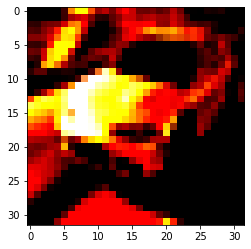

In [252]:
i=data[1].to("cpu")
plt.imshow(i.permute(1,2,0))

In [242]:
i

tensor([[[-0.2589, -0.9838, -0.7942],
         [-0.4335, -1.0806, -0.8543],
         [-0.4018, -0.7901, -0.5087],
         ...,
         [ 2.0274,  2.0986,  2.0906],
         [ 2.0274,  2.0986,  2.0906],
         [ 2.0274,  2.0986,  2.0906]],

        [[-0.2589, -0.9838, -0.7942],
         [-0.4653, -1.0806, -0.8693],
         [-0.4335, -0.7901, -0.5388],
         ...,
         [ 2.0591,  2.1309,  2.1207],
         [ 2.0591,  2.1309,  2.1207],
         [ 2.0591,  2.1309,  2.1207]],

        [[-0.3065, -0.9999, -0.8092],
         [-0.5923, -1.1290, -0.9144],
         [-0.5606, -0.8547, -0.6439],
         ...,
         [ 2.0432,  2.1147,  2.1057],
         [ 2.0432,  2.1147,  2.1057],
         [ 2.0432,  2.1147,  2.1057]],

        ...,

        [[-0.8305, -1.1775, -0.9745],
         [-0.8781, -1.0483, -0.8994],
         [-1.2115, -1.1775, -1.0196],
         ...,
         [-0.8781, -0.6126, -0.3284],
         [-0.9257, -0.6772, -0.3885],
         [-0.9416, -0.7094, -0.4035]],

        [[

In [304]:
def Q_A_label_Train_Eval(dataset, 
                          question_type, 
                          question_class_size, 
                          model_name, 
                          batch_size, 
                          loss_fn, 
                          EPOCHS):
    Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(dataset, 
                                                                                                                                    question_type, 
                                                                                                                                    question_class_size,
                                                                                                                                    batch_size)
    DEVICE= torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model = model_name(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []
    #criterion=nn.CrossEntropyLoss()
    result_df = pd.DataFrame(columns=["dataset", "epoch", "question_type", "question_class_size", "model", "loss_function", "train_loss", "train_acc", "test_acc"])

    for epoch in tqdm(range(EPOCHS)):
        train_loss = Train(model=model, 
                          question_type=question_type,
                          question_class_size=question_class_size,
                          all_class_size=all_class_size,
                          criterion=loss_fn,
                          optimizer=optimizer, 
                          data_loader=Q_A_labels_matrix_train_loader,
                          device=DEVICE, 
                          epoch=epoch, 
                          max_epoch=EPOCHS)
        
        train_acc, test_acc = Eval(model=model, 
                                    evaluation_data_loader_train=train_loader, 
                                    evaluation_data_loader_test=test_loader, 
                                    device=DEVICE, 
                                    epoch=epoch, 
                                    max_epoch=EPOCHS)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        #print(f'TRAIN EPOCH[{epoch+1}/{EPOCHS}] LOSS: {np.mean(train_loss_list)} ACC: {np.mean(train_acc_list)}')
        #print(f'TEST EPOCH[{epoch+1}/{EPOCHS}] ACC:{np.mean(test_acc_list)}')

        result_df = result_df.append({'dataset': get_dataset_name[dataset],
                                      'epoch': epoch+1,
                                      'question_type': get_question_type[question_type], 
                                      'question_class_size': question_class_size, 
                                      'model': get_model[model_name],
                                      'loss_function': get_loss_function[loss_fn],
                                      'train_loss': train_loss,
                                      'train_acc': train_acc,
                                      'test_acc': test_acc}, ignore_index=True)
        
    return result_df

In [306]:
results_df = Q_A_label_Train_Eval(dataset=DataSet.CIFAR10, 
                        question_type=QuestionType.WHICH_ONE, 
                        question_class_size=1, 
                        model_name=mlp_model, 
                        batch_size=512, 
                        loss_fn=mae_loss, 
                        EPOCHS=300)

Files already downloaded and verified


  0%|          | 0/300 [00:00<?, ?it/s]

TRAIN EPOCH[001/300] LOSS:1.614196

TRAIN EPOCH[001/300] ACC:25.918000%

TEST EPOCH[001/300] ACC:25.790000%

TRAIN EPOCH[002/300] LOSS:1.499810

TRAIN EPOCH[002/300] ACC:25.228000%

TEST EPOCH[002/300] ACC:25.220000%

TRAIN EPOCH[003/300] LOSS:1.482683

TRAIN EPOCH[003/300] ACC:26.220000%

TEST EPOCH[003/300] ACC:26.320000%

TRAIN EPOCH[004/300] LOSS:1.457825

TRAIN EPOCH[004/300] ACC:27.080000%

TEST EPOCH[004/300] ACC:26.690000%

TRAIN EPOCH[005/300] LOSS:1.470374

TRAIN EPOCH[005/300] ACC:27.554000%

TEST EPOCH[005/300] ACC:26.700000%

TRAIN EPOCH[006/300] LOSS:1.450444



TypeError: ignored

In [307]:
from tqdm.notebook import tqdm

In [ ]:
for j in tqdm([QuestionType.WHICH_ONE, QuestionType.IS_IN]):
  for i in tqdm(range(1, 10)):
    if (j == QuestionType.WHICH_ONE) and (i == 1):
      results_df = Q_A_label_Train_Eval(dataset=DataSet.CIFAR10, 
                        question_type=j, 
                        question_class_size=i, 
                        model_name=mlp_model, 
                        batch_size=512, 
                        loss_fn=mae_loss, 
                        EPOCHS=300)
    else:
      result_df = Q_A_label_Train_Eval(dataset=DataSet.CIFAR10, 
                        question_type=j, 
                        question_class_size=i, 
                        model_name=mlp_model, 
                        batch_size=512, 
                        loss_fn=mae_loss, 
                        EPOCHS=300)
      results_df = pd.concat([results_df, result_df])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Files already downloaded and verified


  0%|          | 0/300 [00:00<?, ?it/s]

TRAIN EPOCH[001/300] LOSS:1.527071

TRAIN EPOCH[001/300] ACC:26.436000%

TEST EPOCH[001/300] ACC:26.600000%

TRAIN EPOCH[002/300] LOSS:1.410478

TRAIN EPOCH[002/300] ACC:25.134000%

TEST EPOCH[002/300] ACC:25.230000%

TRAIN EPOCH[003/300] LOSS:1.393085

TRAIN EPOCH[003/300] ACC:30.248000%

TEST EPOCH[003/300] ACC:30.830000%

TRAIN EPOCH[004/300] LOSS:1.351022

TRAIN EPOCH[004/300] ACC:28.002000%

TEST EPOCH[004/300] ACC:28.110000%

TRAIN EPOCH[005/300] LOSS:1.312297

TRAIN EPOCH[005/300] ACC:29.852000%

TEST EPOCH[005/300] ACC:29.960000%

TRAIN EPOCH[006/300] LOSS:1.347147

TRAIN EPOCH[006/300] ACC:30.366000%

TEST EPOCH[006/300] ACC:30.270000%

TRAIN EPOCH[007/300] LOSS:1.298320

TRAIN EPOCH[007/300] ACC:31.390000%

TEST EPOCH[007/300] ACC:31.790000%

TRAIN EPOCH[008/300] LOSS:1.294978

TRAIN EPOCH[008/300] ACC:30.914000%

TEST EPOCH[008/300] ACC:31.550000%

TRAIN EPOCH[009/300] LOSS:1.277051

TRAIN EPOCH[009/300] ACC:30.390000%

TEST EPOCH[009/300] ACC:30.930000%

TRAIN EPOCH[010/300

In [ ]:
DataSet.CIFAR10

In [67]:
def Ord_label_Train_Eval(dataset, 
                          model, 
                          batch_size, 
                          loss_fn, 
                          EPOCHS):
    Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(dataset, 
                                                                                                                                   QuestionType.WHICH_ONE, 
                                                                                                                                   5,
                                                                                                                                   batch_size)
    DEVICE= torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model = model(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    train_loss_list = []

    train_acc_list = []
    test_acc_list = []
    #criterion=nn.CrossEntropyLoss()
    result_df = pd.DataFrame(columns=["epoch", "question_type", "question_class_size", "model", "loss", "train_loss", "train_acc", "test_acc"])

    for epoch in range(EPOCHS):
        train_loss,train_acc = Train_Eval(model=model, 
                                          question_type=None,
                                          question_class_size=None,
                                          all_class_size=None,
                                          criterion=loss_fn,
                                          optimizer=optimizer, 
                                          data_loader=train_loader,
                                          evaluation_data_loader_train=train_loader,
                                          evaluation_data_loader_test=test_loader,
                                          device=DEVICE, 
                                          epoch=epoch, 
                                          max_epoch=EPOCHS)
        

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f'TRAIN EPOCH[{epoch+1}/{EPOCHS}] LOSS: {train_loss_list.mean()} ACC:{train_acc_list.mean()}')
        print(f'TEST EPOCH[{epoch+1}/{EPOCHS}] ACC:{test_acc_list.mean()}')

        result_df = result_df.append({'epoch': epoch+1,
                                      'question_type': question_type, 
                                      'question_class_size': question_class_size, 
                                      'train_loss': train_loss_list.mean(), 
                                      'train_acc': train_acc_list.mean(), 
                                      'test_loss': test_acc_list.mean()}, ignore_index=True)
    return result_df

In [69]:
Ord_label_Train_Eval(dataset=DataSet.CIFAR10, 
                      model=mlp_model, 
                      batch_size=256, 
                      loss_fn=nn.CrossEntropyLoss(), 
                      EPOCHS=300)

Files already downloaded and verified
TRAIN EPOCH[001/300] ITR [0001/0196] LOSS:2.35493 ACC:21.750000
TEST   EPOCH[001/300] ITR [0001/0196] ACC:21.540000
TRAIN EPOCH[001/300] ITR [0002/0196] LOSS:2.44134 ACC:22.631000
TEST   EPOCH[001/300] ITR [0002/0196] ACC:22.530000
TRAIN EPOCH[001/300] ITR [0003/0196] LOSS:2.43788 ACC:23.307333
TEST   EPOCH[001/300] ITR [0003/0196] ACC:22.960000
TRAIN EPOCH[001/300] ITR [0004/0196] LOSS:2.48556 ACC:24.546500
TEST   EPOCH[001/300] ITR [0004/0196] ACC:24.247500
TRAIN EPOCH[001/300] ITR [0005/0196] LOSS:2.41284 ACC:25.498400
TEST   EPOCH[001/300] ITR [0005/0196] ACC:25.176000
TRAIN EPOCH[001/300] ITR [0006/0196] LOSS:2.36897 ACC:26.416000
TEST   EPOCH[001/300] ITR [0006/0196] ACC:26.123333
TRAIN EPOCH[001/300] ITR [0007/0196] LOSS:2.32773 ACC:27.098571
TEST   EPOCH[001/300] ITR [0007/0196] ACC:26.835714
TRAIN EPOCH[001/300] ITR [0008/0196] LOSS:2.31489 ACC:27.624250
TEST   EPOCH[001/300] ITR [0008/0196] ACC:27.301250
TRAIN EPOCH[001/300] ITR [0009/019

KeyboardInterrupt: ignored